In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
eval_dir = "/Users/raaed/Desktop/hallucination_project/phase_1_evaluation/evaluations"
domains = ["general", "medical", "legal", "finance"]
dfs = {}
for domain in domains:
    path = os.path.join(eval_dir, f"{domain}_evaluated_with_final.csv")
    if os.path.exists(path):
        df = pd.read_csv(path)
        df["domain"] = domain
        dfs[domain] = df
    else:
        print(f"Missing file: {path} — Skipping...")

if dfs:
    all_data = pd.concat(dfs.values(), ignore_index=True)
    print(f"Loaded {len(all_data)} rows from {len(dfs)} domains.")
else:
    print("No data loaded. Check file paths.")

Loaded 790 rows from 4 domains.


### Bar Plot of Hallucinated vs. Not Hallucinated per Domain

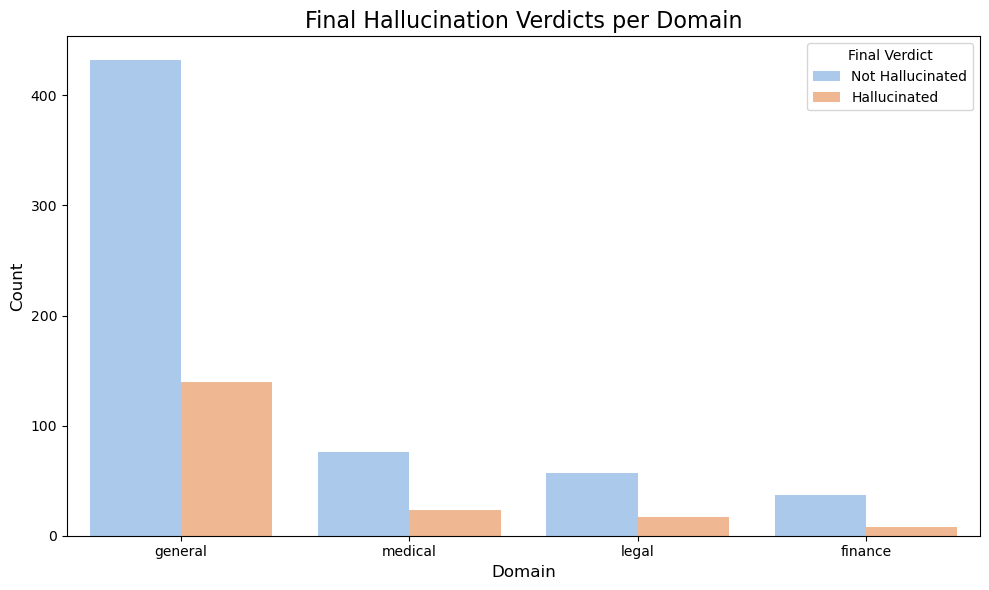

In [8]:
os.makedirs("visualizations", exist_ok=True)
out_path = os.path.join("visualizations", "final_hallucination_verdicts.png")

plt.figure(figsize=(10, 6))
sns.countplot(data=all_data, x="domain", hue="final_verdict", palette="pastel")
plt.title("Final Hallucination Verdicts per Domain", fontsize=16)
plt.xlabel("Domain", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Final Verdict")
plt.tight_layout()

plt.savefig(out_path, dpi=300)
plt.show()

The bar chart illustrates the distribution of hallucinated versus non-hallucinated responses across four domains: general, medical, legal, and finance. 
Among these, the general domain contains the largest volume of evaluated samples, with a substantial proportion labeled as hallucinated. This trend is expected due to the broad and open-ended nature of general knowledge queries, which are more susceptible to hallucinations from large language models. 
In contrast, the medical, legal, and finance domains show significantly fewer total samples, and the number of hallucinated responses is comparatively lower. This may indicate that the model performs more reliably in structured and specialized domains, where information tends to be fact-based and less ambiguous. 
These findings reinforce the importance of domain-specific evaluation in hallucination detection. They also validate the use of a composite, weighted scoring system and support the choice of a 0.6 threshold for final verdict classification, as it balances the trade-off between strictness and tolerance across varied knowledge domains.

### Final Score Distribution by Domain

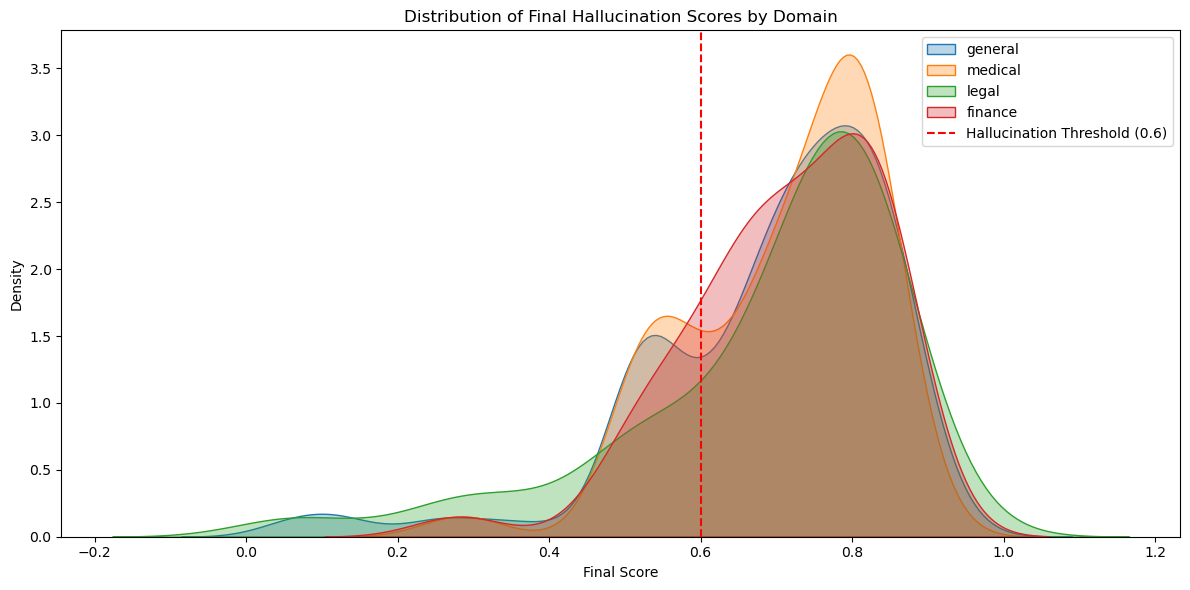

In [11]:
os.makedirs("visualizations", exist_ok=True)
out_path = os.path.join("visualizations", "kde_graph.png")

plt.figure(figsize=(12, 6))
for domain, df in dfs.items():
    sns.kdeplot(df['final_score'], label=domain, fill=True, alpha=0.3)

plt.axvline(0.6, color='red', linestyle='--', label='Hallucination Threshold (0.6)')
plt.title("Distribution of Final Hallucination Scores by Domain")
plt.xlabel("Final Score")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()

plt.savefig(out_path, dpi=300)
plt.show()

The above graph illustrates the distribution of final hallucination scores across all four domains — general, medical, legal, and finance — using kernel density estimation (KDE). This visualization offers insight into how concentrated or dispersed hallucination likelihoods are within each domain. A vertical red dashed line marks the hallucination threshold set at 0.6. Notably, the bulk of scores for all domains are clustered above this threshold, particularly between 0.6 and 0.9, indicating that most LLM responses were deemed accurate under our metric ensemble. However, the presence of leftward tails — more prominent in the legal and medical domains — highlights edge cases that triggered hallucination flags. This plot validates our choice of the 0.6 threshold as a balanced decision point: it effectively separates likely hallucinated outputs from valid ones while still capturing borderline cases that merit further scrutiny in high-stakes domains like legal and finance.

### Boxplot of Final Hallucination Scores by Domain

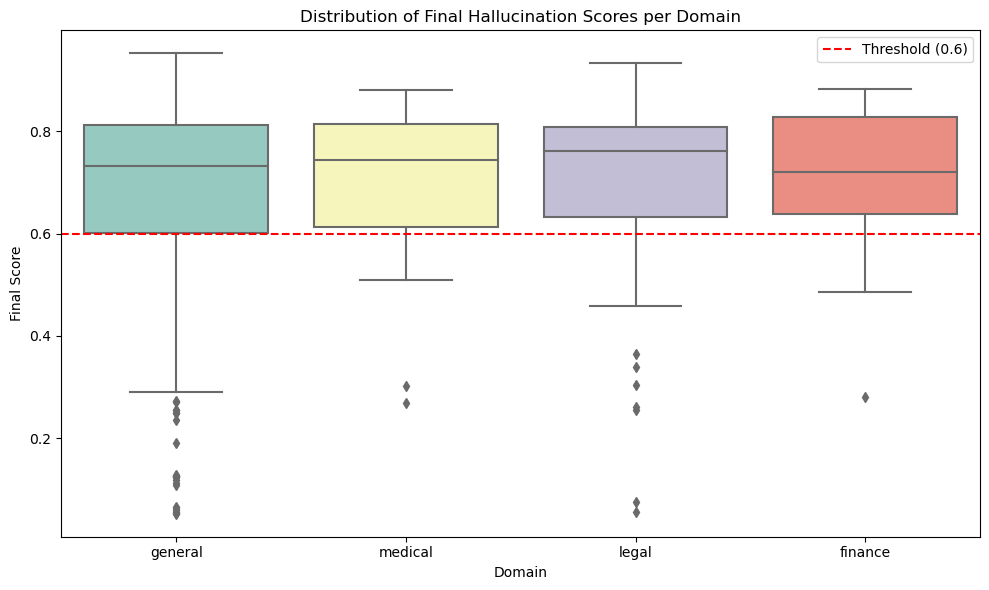

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_data, x="domain", y="final_score", palette="Set3")
plt.title("Distribution of Final Hallucination Scores per Domain")
plt.xlabel("Domain")
plt.ylabel("Final Score")
plt.axhline(0.6, color='red', linestyle='--', label="Threshold (0.6)")
plt.legend()
plt.tight_layout()
plt.show()

The figure above presents the distribution of final hallucination scores across four domains—general, medical, legal, and finance—using a boxplot. Each box represents the interquartile range (IQR) of scores (from the 25th to the 75th percentile), while the line inside each box shows the median hallucination score for that domain. Outliers are shown as individual points outside the whiskers.

A red dashed line is drawn at the threshold value of 0.6, which is used to determine whether a response is hallucinated. Scores above this line are generally considered non-hallucinated, while those below it indicate potential hallucinations. The chart reveals that:

- Most responses in all domains have scores above the threshold, suggesting strong alignment with ground truth.

- The legal and finance domains show slightly tighter score distributions, while the general domain exhibits more variability and a higher number of low-scoring outliers.

- The medical domain has consistently high scores with minimal outliers, indicating strong factual alignment in that dataset.

This visualization is important because it helps identify how close domain-specific responses are to being hallucinated and evaluates how well the current scoring system separates reliable outputs from hallucinated ones.

### Hallucination Rate by Method and Domain

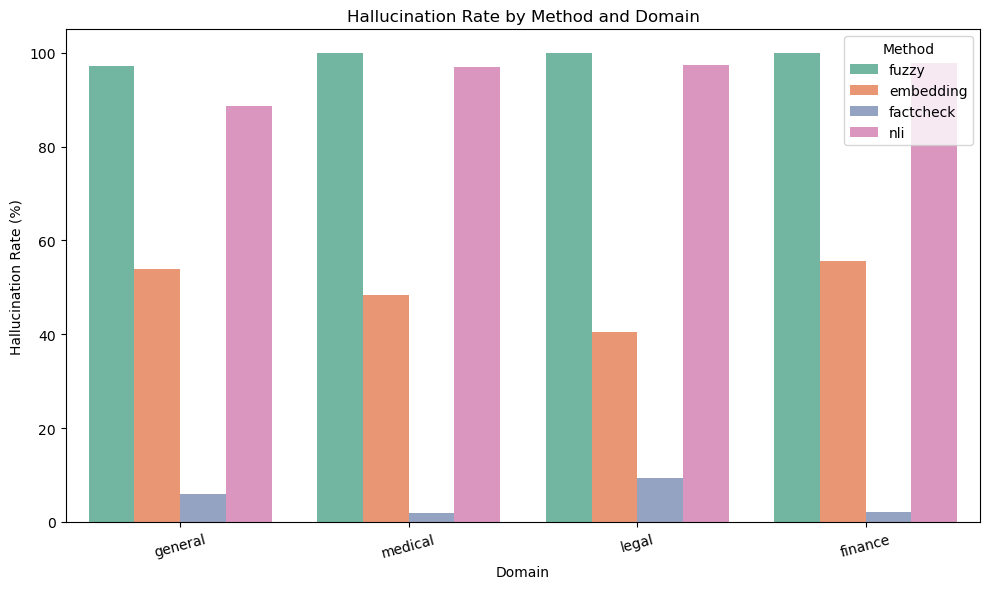

In [12]:
os.makedirs("visualizations", exist_ok=True)
out_path = os.path.join("visualizations", "hallucination_rate_by_method.png")

domains = ["general", "medical", "legal", "finance"]
method_rates = []
for domain in domains:
    path = os.path.join(eval_dir, f"{domain}_evaluated_with_final.csv")
    df = pd.read_csv(path)
    methods = ["fuzzy_verdict", "embedding_verdict", "factcheck_verdict", "nli_verdict"]
    for col in methods:
        if col in df.columns:
            df[col] = df[col].map({"Yes": 1, "No": 0})

    for method in methods:
        if method in df.columns:
            halluc_rate = (1 - df[method].mean()) * 100
            method_rates.append({
                "domain": domain,
                "method": method.replace("_verdict", ""),
                "hallucination_rate": halluc_rate
            })
rate_df = pd.DataFrame(method_rates)
plt.figure(figsize=(10, 6))
sns.barplot(data=rate_df, x="domain", y="hallucination_rate", hue="method", palette="Set2")
plt.title("Hallucination Rate by Method and Domain")
plt.ylabel("Hallucination Rate (%)")
plt.xlabel("Domain")
plt.xticks(rotation=15)
plt.legend(title="Method")
plt.tight_layout()

plt.savefig(out_path, dpi=300)
plt.show()

This bar graph visualizes the hallucination rates across four evaluation methods (fuzzy, embedding, factcheck, nli) for each domain (general, medical, legal, finance). The hallucination rate is calculated as the percentage of incorrect responses (i.e., responses marked as hallucinations) by each evaluation method.

Key Observations:
- Fuzzy matching yields the highest hallucination rate, nearing 100% across all domains. This indicates that fuzzy logic tends to be overly strict and flags nearly all LLM responses as hallucinations, regardless of semantic alignment.

- NLI (Natural Language Inference) also shows very high hallucination rates (close to or above 95%) for all domains. This may suggest that the NLI model is either highly sensitive or possibly misaligned with how LLMs generate factual responses.

- Embedding-based similarity has moderate hallucination rates, ranging from 41% (legal) to 56% (finance). These scores are relatively balanced and may provide a better compromise between strictness and flexibility.

- Fact-checking performs the best in terms of accuracy, with hallucination rates below 10% in all domains. This suggests that the fact-checking method is more reliable and conservative in flagging hallucinations.

**Interpretation**

Each method brings its own bias:

- Fuzzy and NLI are highly pessimistic, flagging most content as hallucinated.

- Embedding is moderate and useful for capturing semantic similarity.

- Factcheck is optimistic, flagging hallucinations only when there's strong contradiction with known facts.

This graph is crucial for selecting or combining methods in a hallucination evaluation pipeline. A high hallucination rate is not necessarily bad—it may reflect a stricter standard. However, an effective evaluation system should balance precision and recall, possibly by aggregating signals from multiple methods.